# 基于注意力的神经机器翻译

此笔记本训练一个将西班牙语翻译为英语的序列到序列（sequence to sequence，简写为 seq2seq）模型

训练完此笔记本中的模型后，你将能够输入一个西班牙语句子，例如 "¿todavia estan en casa?"，并返回其英语翻译 "are you still at home?"

对于一个简单的例子来说，翻译质量令人满意。但是更有趣的可能是生成的注意力图：它显示在翻译过程中，输入句子的哪些部分受到了模型的注意。

![attention](https://tensorflow.org/images/spanish-english.png)

请注意：运行这个例子用一个 P100 GPU 需要花大约 10 分钟。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## 下载和准备数据集

我们将使用 http://www.manythings.org/anki/ 提供的一个语言数据集。这个数据集包含如下格式的语言翻译对：

这个数据集中有很多种语言可供选择。我们将使用英语 - 西班牙语数据集。为方便使用，我们在谷歌云上提供了此数据集的一份副本。但是你也可以自己下载副本。下载完数据集后，我们将采取下列步骤准备数据：

+ 给每个句子添加一个 开始 和一个 结束 标记（token）。
+ 删除特殊字符以清理句子。
+ 创建一个单词索引和一个反向单词索引（即一个从单词映射至 id 的词典和一个从 id 映射至单词的词典）。
+ 将每个句子填充（pad）到最大长度。

In [2]:
# 下载文件
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)
path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

In [5]:
# 将 unicode 文件转换为 ascii
def unicode_to_ascii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s)
                  if unicodedata.category(c) != "Mn")

# 预处理
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    # 参考：https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)  # \1 表示重复匹配到的内容
    w = re.sub(r'[" "]+', " ", w)
    
    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # 给句子加上开始和结束的标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w
    

In [6]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(type(preprocess_sentence(en_sentence)))
print(preprocess_sentence(sp_sentence).encode("utf-8"))
print(type(preprocess_sentence(sp_sentence).encode("utf-8")))

<start> may i borrow this book ? <end>
<class 'str'>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'
<class 'bytes'>


In [7]:
# 1. 去除重音符号
# 2. 清理句子
# 3. 返回这样格式的单词对：[ENGLISH, SPANISH]

def create_dataset(path, num_examples):
    lines = io.open(path, encoding="utf-8").read().strip().split("\n")
    
    word_pairs = [[preprocess_sentence(w) for w in l.split("\t")] for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [8]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [9]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [10]:
def tokenize(lang):
    # 初始化分词器，并生成词典
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="")
    lang_tokenizer.fit_on_texts(lang)
    # 利用词典将文本数据转为id表示
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # 将数据pad成统一的长度，以所有数据中最大长度为准，长度不够的补零
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="post")
    
    return tensor, lang_tokenizer

In [11]:
def load_dataset(path, num_examples=None):
    # 创建清理过的输出和输出对
    targ_lang, inp_lang = create_dataset(path, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 限制数据集的大小以加快实验速度（可选）

在超过 10 万个句子的完整数据集上训练需要很长时间。为了更快地训练，我们可以将数据集的大小限制为 3 万个句子（当然，翻译质量也会随着数据的减少而降低）：

In [12]:
# 尝试实验不同大小的数据集
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 计算目标张量的最大长度（max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [13]:
# 采用 80-20 的比例切分数据集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [14]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d ---> %s" % (t, lang.index_word[t]))

In [15]:
print("Input language: index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language: index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input language: index to word mapping
1 ---> <start>
210 ---> dame
9 ---> el
1120 ---> mapa
3 ---> .
2 ---> <end>

Target Language: index to word mapping
1 ---> <start>
98 ---> give
17 ---> me
13 ---> the
921 ---> map
3 ---> .
2 ---> <end>


## 创建数据集

In [16]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BATCH_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 编写编码器 （encoder） 和解码器 （decoder） 模型

实现一个基于注意力的编码器 - 解码器模型

图和公式是 Luong 的论文中注意力机制的一个例子。

![encoder_decoder](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

输入经过编码器模型，编码器模型为我们提供形状为 (批大小，最大长度，隐藏层大小) 的编码器输出和形状为 (批大小，隐藏层大小) 的编码器隐藏层状态。

下面是所实现的方程式：

![1](https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg)
![2](https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg)

本教程的编码器采用 Bahdanau 注意力

+ FC = 完全连接（密集）层
+ EO = 编码器输出
+ H = 隐藏层状态
+ X = 解码器输入

伪代码:
+ score = FC(tanh(FC(EO) + FC(H)))
+ attention weights = softmax(score, axis = 1)。 Softmax 默认被应用于最后一个轴，但是这里我们想将它应用于 第一个轴, 因为分数 （score） 的形状是 (批大小，最大长度，隐藏层大小)。最大长度 （max_length） 是我们的输入的长度。因为我们想为每个输入分配一个权重，所以 softmax 应该用在这个轴上。
+ context vector = sum(attention weights * EO, axis = 1)。选择第一个轴的原因同上。
+ embedding output = 解码器输入 X 通过一个嵌入层。
+ merged vector = concat(embedding output, context vector)

每个步骤中所有向量的形状已在代码的注释中阐明：

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer="glorot_uniform")
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))  # 初始化的hidden shape (batch, enc_hidden_units)

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

#样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) # (enc_units, dec_units)
        self.W2 = tf.keras.layers.Dense(units) # (enc_units, dec_units)
        self.V = tf.keras.layers.Dense(1) # (dec_units, 1)
        
    def call(self, query, values):
        # 隐藏层的形状 == （批大小，隐藏层大小）
        # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
        # 这样做是为了执行加法以计算分数 
        # query (batch, 1, enc_units)
        hidden_with_time_axis = tf.expand_dims(query, 1)
        
        # 分数的形状 == （批大小，最大长度，1）
        # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
        # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
        # values (batch, max_length, enc_units)
        # hidden_with_time_axis (batch, 1, enc_units)
        # score(batch, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis) 
        ))
        
        # 注意力权重 attention_weights shape (batch, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # 上下文向量 context_vector shape 求和后 (batch, enc_units)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [22]:
attention_layer = BahdanauAttention(10) # dec_units = 10
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform"
        )
        self.fc = tf.keras.layers.Dense(vocab_size) # (dec_unit, vocab_size)
        
        # 注意力
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # 编码器输出enc_output,shape (batch, max_length, enc_units)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        
        # x 在通过嵌入层后的形状 (batch, 1, embedding_dim)
        x = self.embedding(x)
        
        # x 在拼接(concatenation)后shape (batch， 1， embedding + enc_units)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # 将合并后的向量传送到GRU
        output, state = self.gru(x)
        
        # reshape前output形状为：(batch, 1, dec_units)
        # reshape后output形状为：(batch, dec_units)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # 输出shape （batch, vocab_size）
        x = self.fc(output)
        
        return x, state, attention_weights

In [24]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _,_ = decoder(tf.random.uniform((64, 1)),
                                   sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## 定义优化器和损失函数

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

## 检查点（基于对象保存）

In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 训练

+ 将 输入 传送至 编码器，编码器返回 编码器输出 和 编码器隐藏层状态。
+ 将编码器输出、编码器隐藏层状态和解码器输入（即 开始标记）传送至解码器。
+ 解码器返回 预测 和 解码器隐藏层状态。
+ 解码器隐藏层状态被传送回模型，预测被用于计算损失。
+ 使用 教师强制 （teacher forcing） 决定解码器的下一个输入。
+ 教师强制 是将 目标词 作为 下一个输入 传送至解码器的技术。
+ 最后一步是计算梯度，并将其应用于优化器和反向传播。

In [27]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([targ_lang.word_index["<start>"]] * BATCH_SIZE, 1)
        
        # teacher forcing- 将目标词作为下一个输入
        for t in range(1, targ.shape[1]):
            # 将编码器输出 enc_output 传送至解码器
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_hidden)
            
            loss += loss_function(targ[:, t], predictions)
            
            # 使用teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [37]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # 每 2 个周期（epoch），保存（检查点）一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.1744
Epoch 1 Batch 100 Loss 1.1815
Epoch 1 Batch 200 Loss 1.1382
Epoch 1 Batch 300 Loss 1.0925
Epoch 1 Loss 1.1354
Time taken for 1 epoch 76.82737469673157 sec

Epoch 2 Batch 0 Loss 1.0683
Epoch 2 Batch 100 Loss 1.1399
Epoch 2 Batch 200 Loss 1.0696
Epoch 2 Batch 300 Loss 1.0671
Epoch 2 Loss 1.0983
Time taken for 1 epoch 80.0094006061554 sec

Epoch 3 Batch 0 Loss 1.0432
Epoch 3 Batch 100 Loss 1.0751
Epoch 3 Batch 200 Loss 1.0259
Epoch 3 Batch 300 Loss 1.0064
Epoch 3 Loss 1.0709
Time taken for 1 epoch 76.92764091491699 sec

Epoch 4 Batch 0 Loss 1.0295
Epoch 4 Batch 100 Loss 0.9951
Epoch 4 Batch 200 Loss 1.0635
Epoch 4 Batch 300 Loss 1.0139
Epoch 4 Loss 1.0398
Time taken for 1 epoch 80.13540959358215 sec

Epoch 5 Batch 0 Loss 0.9954
Epoch 5 Batch 100 Loss 1.0696
Epoch 5 Batch 200 Loss 0.9890
Epoch 5 Batch 300 Loss 0.9677
Epoch 5 Loss 1.0178
Time taken for 1 epoch 77.06500339508057 sec

Epoch 6 Batch 0 Loss 1.0355
Epoch 6 Batch 100 Loss 1.0188
Epoch 6 Batch 200 Loss 

## 翻译

+ 评估函数类似于训练循环，不同之处在于在这里我们不使用 教师强制。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
+ 当模型预测 结束标记 时停止预测。
+ 存储 每个时间步的注意力权重。

请注意：对于一个输入，编码器输出仅计算一次。

In [38]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [39]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [40]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 恢复最新的检查点并验证

In [41]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: are you re you re you re you re you re 


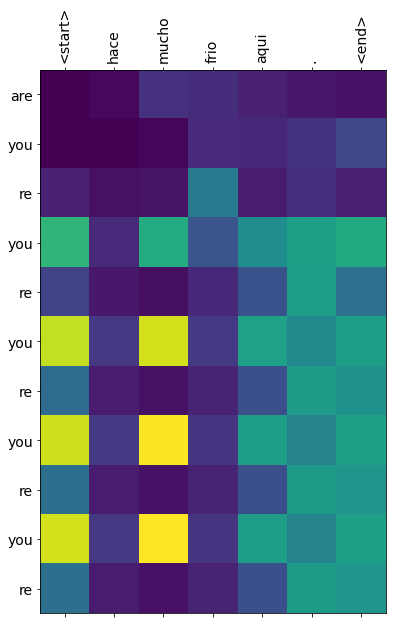

In [42]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: is this is tom is this is tom is this is 


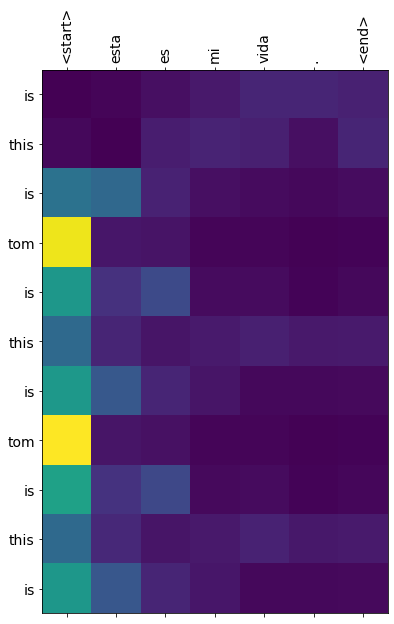

In [34]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: i m a doctor ? <end> 


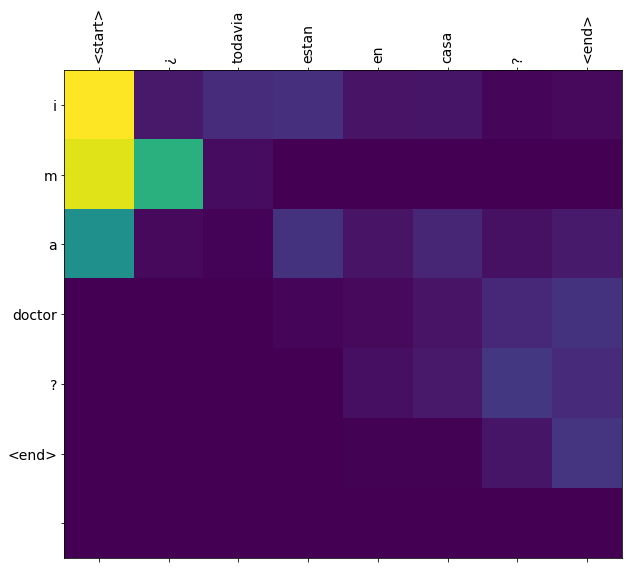

In [35]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: why are not be not like to be back in t 


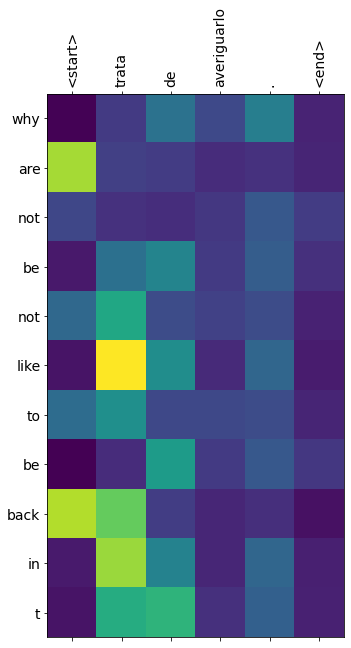

In [36]:
# 错误的翻译
translate(u'trata de averiguarlo.')